In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
# from labspace import singleTransfer
import pandas as pd


In [2]:
example_prefix = 'examples'
input_image_prefix, ref_image_prefix = ('0008_002','0010')
print(input_image_prefix, ref_image_prefix)

inputImg_bgr=(cv2.imread("../data/inputs/"+example_prefix+"/"+input_image_prefix+".png",cv2.IMREAD_COLOR))
inputImg= np.float32(cv2.cvtColor(inputImg_bgr, cv2.COLOR_BGR2Lab))

refImg_bgr=(cv2.imread("../data/inputs/"+example_prefix+"/"+ref_image_prefix+".png",cv2.IMREAD_COLOR))
refImg=np.float32(cv2.cvtColor(refImg_bgr, cv2.COLOR_BGR2Lab))

refImg_bg=np.float32(cv2.imread("../data/inputs/"+example_prefix+"/"+ref_image_prefix+".jpg",cv2.IMREAD_COLOR))

inputImg_mask = cv2.imread("../data/inputs/"+example_prefix+"/"+input_image_prefix+"_mask.png")

# refImg_mask = cv2.imread("../data/inputs/example1/2910450431_56f1c774ed_z_mask.png",0)

style_lm = np.array(pd.read_csv("../data/inputs/"+example_prefix+"/"+ref_image_prefix+".lm", header=None),dtype='float32')

input_lm = np.array(pd.read_csv("../data/inputs/"+example_prefix+"/"+input_image_prefix+".lm", header=None),dtype='float32')


0008_002 0010


In [3]:
noOfLevels=6

def lapStack(input_img):
    h,w=np.shape(input_img)
    lapStack=np.empty((h,w,noOfLevels))

    lap=[]
    for i in range(0,noOfLevels):
        sigma2 = 2**(i+1)
        ksize2 = 6*sigma2-1
        
        gaBlur2=cv2.GaussianBlur(input_img.copy(),(ksize2,ksize2),sigma2,sigma2)
        if(i==0):
            lap.append(input_img-gaBlur2)
        else:
            sigma1 = 2**i
            ksize1 = 6*sigma1-1
            gaBlur1=cv2.GaussianBlur(input_img.copy(),(ksize1,ksize1),sigma1,sigma1)
            lap.append(gaBlur1-gaBlur2)
            if(i== noOfLevels-1):
                lap.append(gaBlur2)
    return lap

def localEnergyStack(gausStack):
    S=[]
    #gausStack=np.array(gausStack)
    #gausStackSq=np.square(gausStack)
    gausStackSq=[i**2 for i in gausStack]
    
    for i in range(noOfLevels):
        sigma=2**(i+1)
        # c=0
        # if ((5*sigma)%2==0):c=1
        # # S.append(cv2.GaussianBlur(gausStackSq[i],(5*sigma+c,5*sigma+c),sigma,sigma))
        S.append(cv2.GaussianBlur(gausStackSq[i],(6*sigma-1,6*sigma-1),sigma,sigma))
        # S.append(np.sqrt(cv2.GaussianBlur(gausStackSq[i],(6*sigma-1,6*sigma-1),sigma,sigma)))
    
    return S


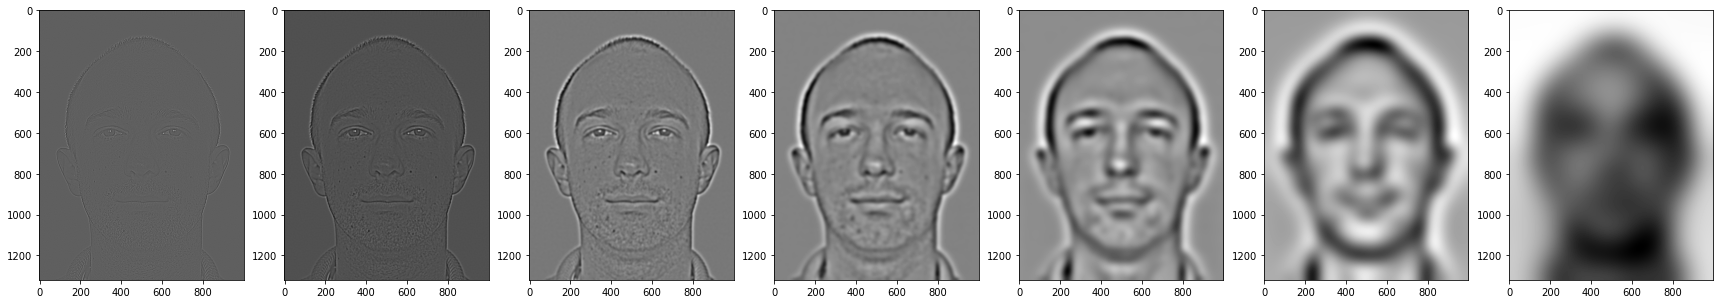

In [4]:
inputImg_,refImg_,style_lm,input_lm = (inputImg[:,:,0], refImg[:,:,0], style_lm, input_lm)
lapIn=lapStack(inputImg_)
lapRef=lapStack(refImg_)

fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels+1):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(lapIn[i],cmap="gray")

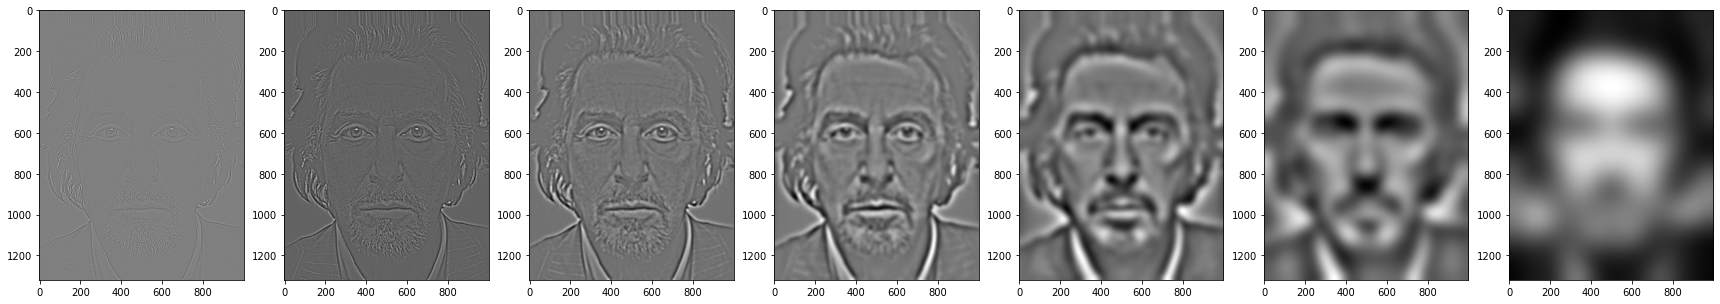

In [5]:
fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels+1):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(lapRef[i],cmap="gray")

0 2 11
1 4 23
2 8 47
3 16 95


/tmp/ipykernel_790169/91864550.py:15: RuntimeWarning: invalid value encountered in divide
  gaBlur2 = gaBlur2/gaBlur2_mask
/tmp/ipykernel_790169/91864550.py:25: RuntimeWarning: invalid value encountered in divide
  gaBlur1 = gaBlur1/gaBlur1_mask


4 32 191
5 64 383


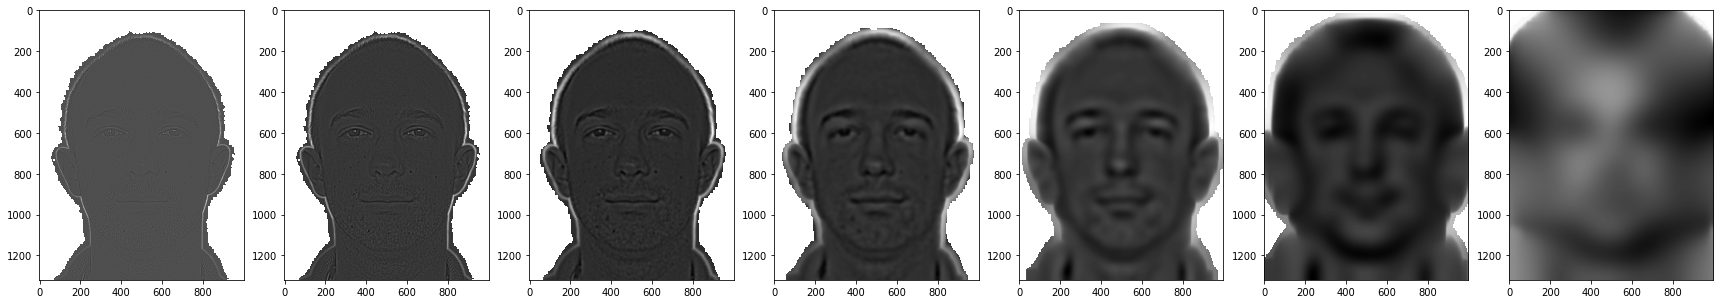

In [6]:
def lapStack_withMask(input_img, input_img_mask):
    h,w=np.shape(input_img)
    lapStack=np.empty((h,w,noOfLevels))
    
    input_img_masked = input_img*input_img_mask

    lap=[]
    for i in range(0,noOfLevels):
        sigma2 = 2**(i+1)
        ksize2 = 6*sigma2-1
        print(i, sigma2, ksize2)
        gaBlur2 = cv2.GaussianBlur(input_img_masked.copy(),(ksize2,ksize2),sigma2,sigma2)
        
        gaBlur2_mask = cv2.GaussianBlur(input_img_mask.copy(),(ksize2,ksize2),sigma2,sigma2)
        gaBlur2 = gaBlur2/gaBlur2_mask
        
        if(i==0):
            lap.append(input_img-gaBlur2)
        else:
            sigma1 = 2**i
            ksize1 = 6*sigma1-1
            gaBlur1 = cv2.GaussianBlur(input_img_masked.copy(),(ksize1,ksize1),sigma1,sigma1)
            
            gaBlur1_mask = cv2.GaussianBlur(input_img_mask.copy(),(ksize1,ksize1),sigma1,sigma1)
            gaBlur1 = gaBlur1/gaBlur1_mask
            
            lap.append(gaBlur1-gaBlur2)
            if(i== noOfLevels-1):
                lap.append(gaBlur2)
    return lap

lapIn_masked = lapStack_withMask(inputImg[:,:,0], np.float32(inputImg_mask[:,:,0]))
fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels+1):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(lapIn_masked[i],cmap="gray")

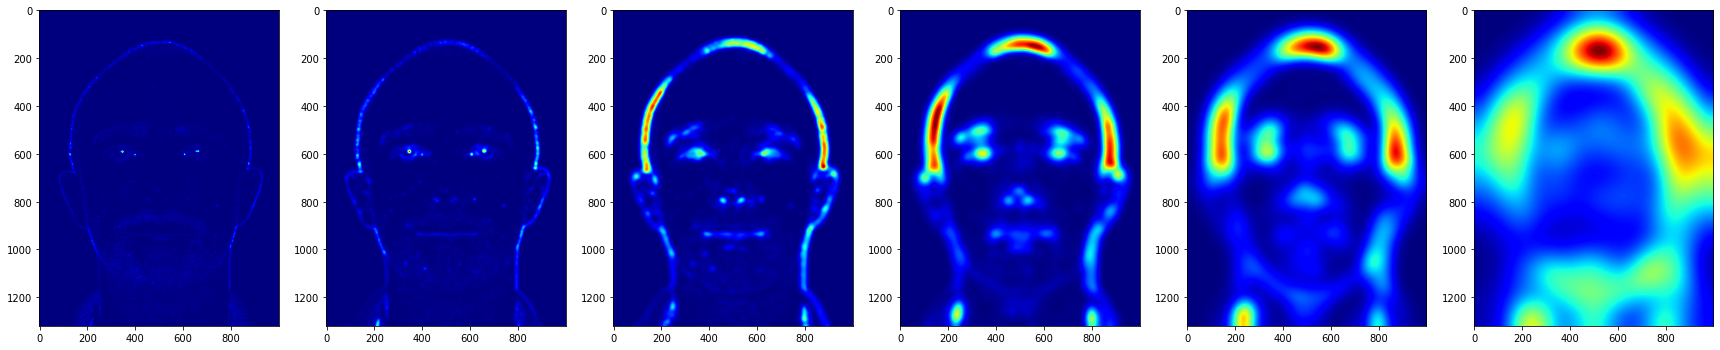

In [7]:
Si=localEnergyStack(lapIn)
Sr=localEnergyStack(lapRef)

fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    # plt.imshow(Si[i],cmap="gray")
    plt.imshow(Si[i],cmap="jet")

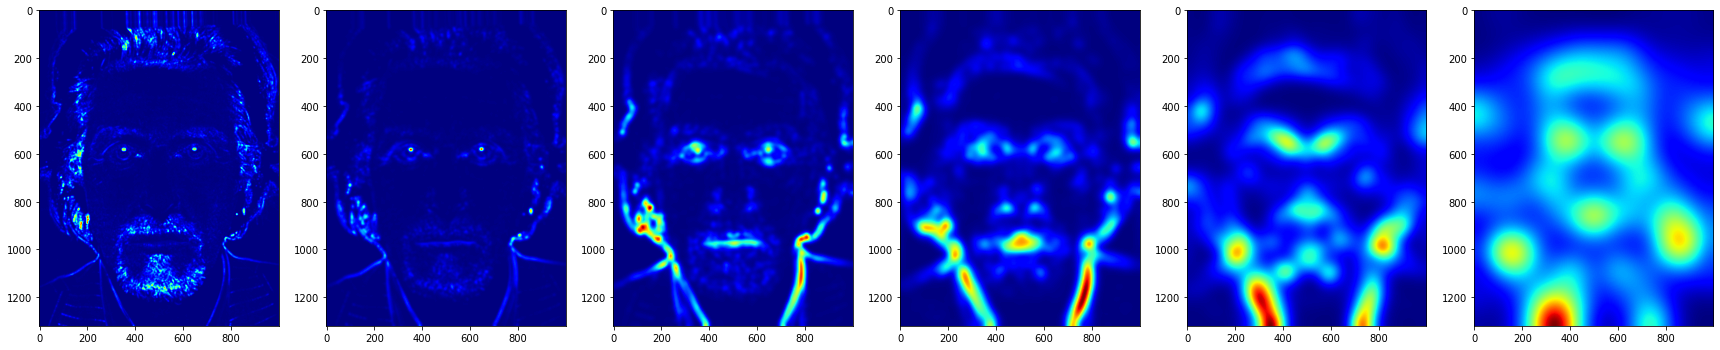

In [8]:
fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    # plt.imshow(Sr[i],cmap="gray")
    plt.imshow(Sr[i],cmap="jet")

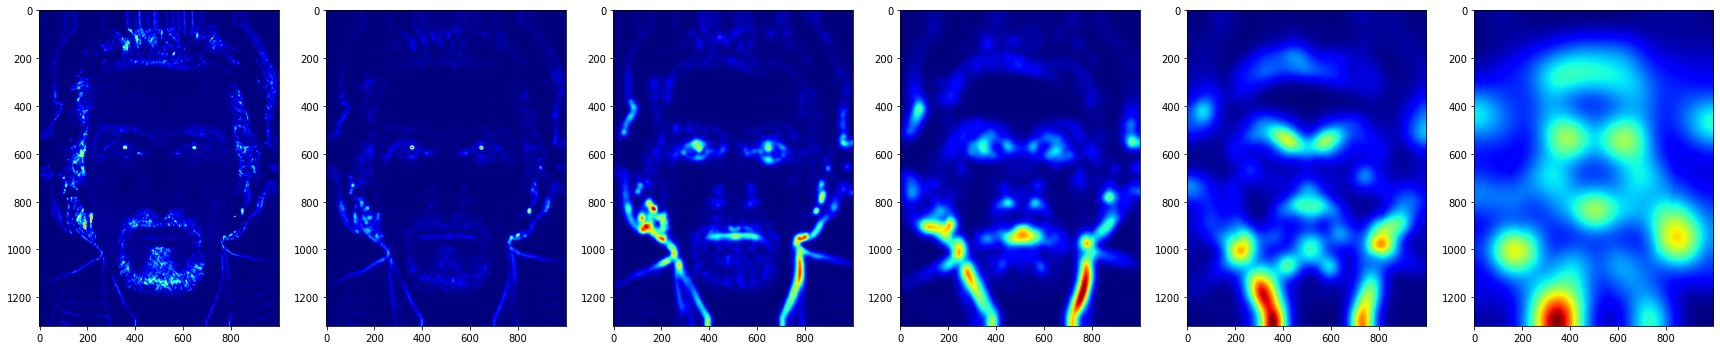

In [9]:
## Warp function
from WrapOperator import wrapOperator

vy, vx, yy, xx =wrapOperator(style_img=refImg_.copy(), input_img=inputImg_.copy(), style_lm=style_lm, input_lm=input_lm)

wrLoRe=[]
for i in range(noOfLevels):
    tempwarp = np.ones(Sr[i].shape)
    tempwarp[yy.astype(int), xx.astype(int)] = Sr[i][vy, vx]
    wrLoRe.append(tempwarp)

fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    # plt.imshow(wrLoRe[i],cmap="gray")
    plt.imshow(wrLoRe[i],cmap="jet")

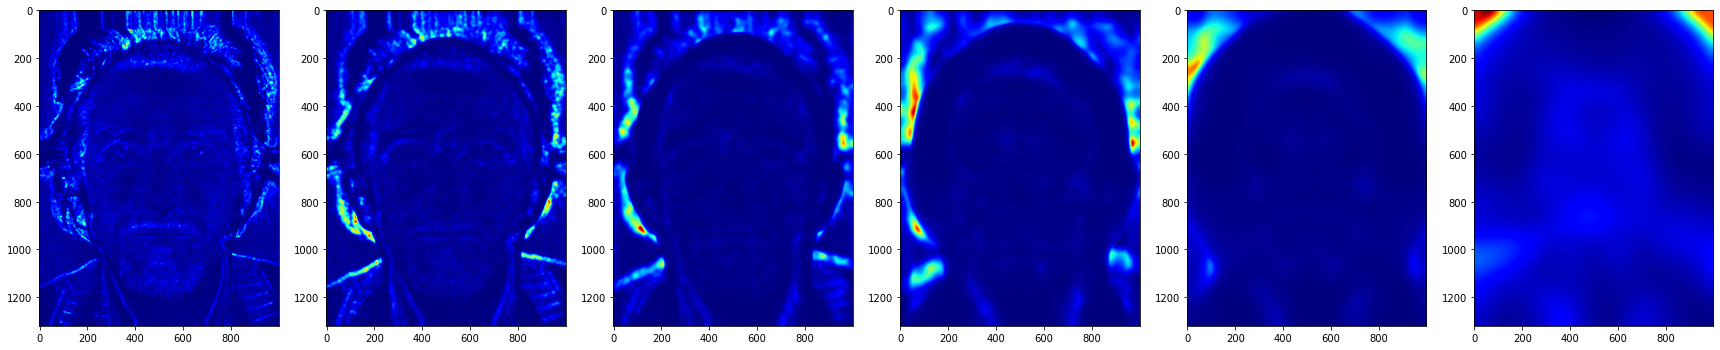

In [10]:
##Robust Transfer

#calculating the gain
norSi=np.zeros_like(np.array(Si))
gain=np.zeros_like(np.array(Si))
for i in range(noOfLevels):
    norSi[i]=Si[i]
    gain[i]=np.sqrt(np.array(wrLoRe[i])/(np.array(norSi[i])+0.0001))

fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    # plt.imshow(gain[i],cmap="gray")
    plt.imshow(gain[i],cmap="jet")

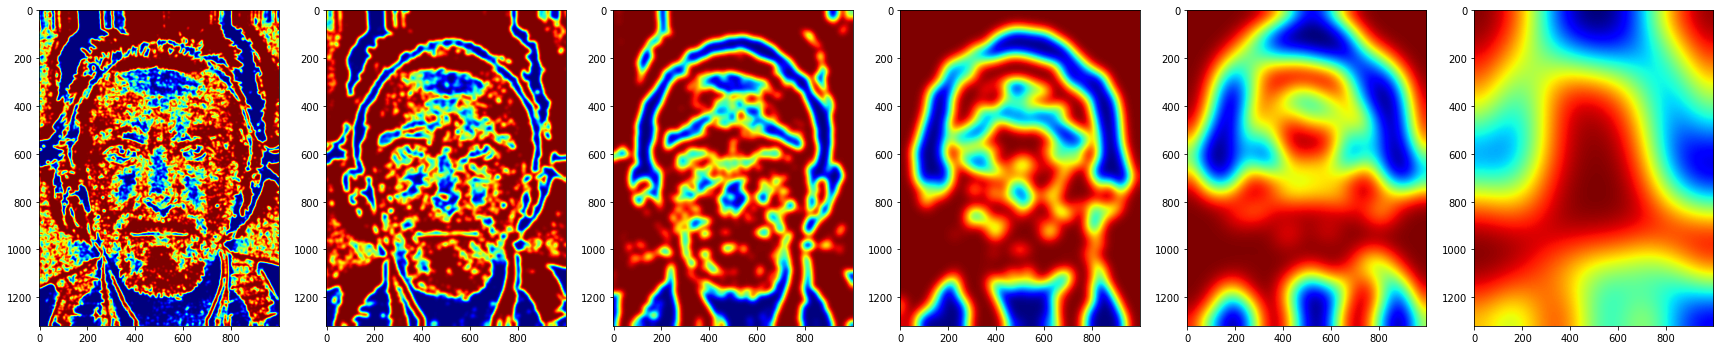

In [11]:
#robust gain
##threshold the gain bw 0.9 to 2.8
gain[gain>2.8]=2.8
gain[gain<0.9]=0.9

lapout=[]
robGain=[]
for i in range(6):
    sigma2 = 3*(2**(i))
    ksize2 = 6*sigma2-1
    robGain.append(cv2.GaussianBlur(gain[i],(ksize2,ksize2),sigma2,sigma2))
    # robGain.append(cv2.GaussianBlur(gain[i],(5*(3*(2**(7)))+1,5*(3*(2**(7)))+1),3*(2**(7)),(3*(2**(7)))))
    lapout.append(lapIn[i]*robGain[i])

fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    # plt.imshow(robGain[i],cmap="gray")
    plt.imshow(robGain[i],cmap="jet")


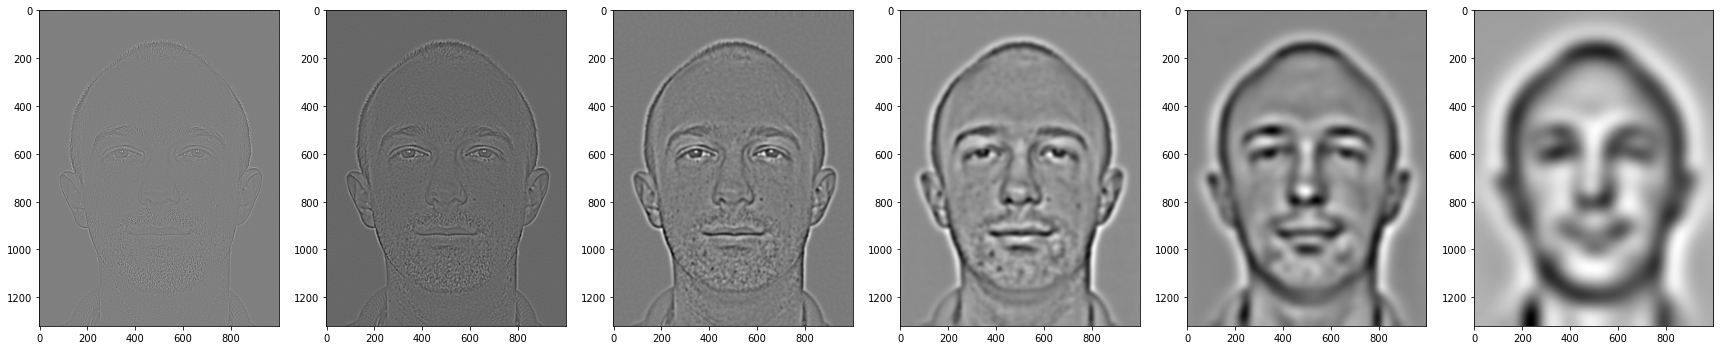

In [12]:
fig = plt.figure(figsize=(30, 30))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    plt.imshow(lapout[i],cmap="gray")


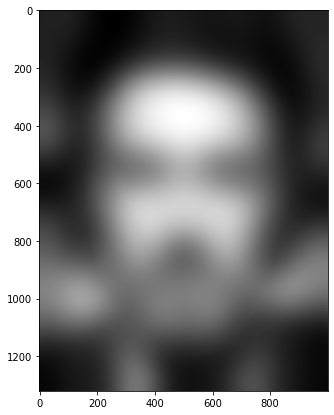

In [13]:
resOut = np.ones(refImg_.shape)
resOut[yy.astype(int), xx.astype(int)] =lapRef[6][vy, vx]

plt.figure(figsize=(7,7))
plt.imshow(resOut,cmap="gray")

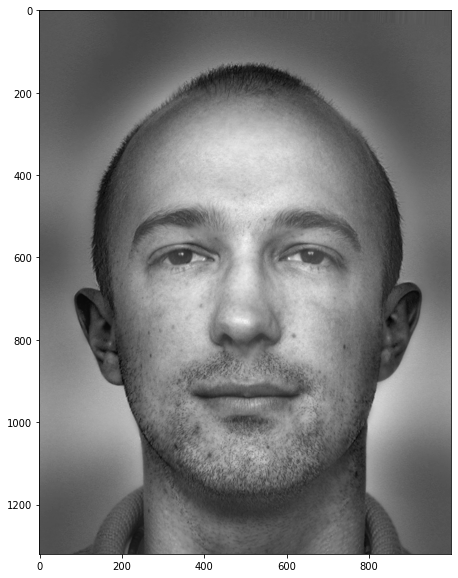

In [14]:
## find the reconstructed output from laplacian pyramids and the residue
### acc to paper remove the first 3 high freq. layers
finReImg=np.zeros_like(lapout[0])
for i in range(6-1,-1,-1):
    finReImg+=lapout[i]
finReImg+=resOut

inputImg_transformed = inputImg.copy()
m1, m2 = (np.min(inputImg_transformed[:,:,0]), np.max(inputImg_transformed[:,:,0]))
inputImg_transformed[:,:,0] = finReImg.copy()
inputImg_transformed[:,:,0] = (inputImg_transformed[:,:,0]-np.min(inputImg_transformed[:,:,0]))*(m2-m1)/(np.max(inputImg_transformed[:,:,0])-np.min(inputImg_transformed[:,:,0])) + m1
inputImg_transformed_u8 = inputImg_transformed.astype('uint8')
inputImg_transformed_u8_rgb = cv2.cvtColor(inputImg_transformed_u8.copy(), cv2.COLOR_Lab2RGB)
inputImg_transformed_u8_gray = cv2.cvtColor(inputImg_transformed_u8_rgb, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(inputImg_transformed_u8_gray, cmap='gray')

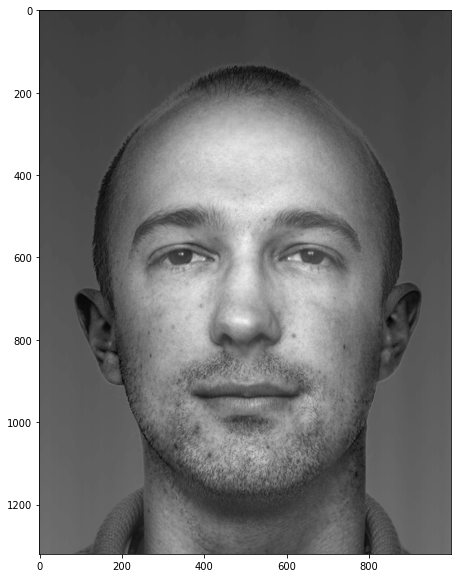

In [15]:
### background replacement
inputImg_mask = inputImg_mask/255
tempOut = np.float32(inputImg_transformed_u8_rgb)
outImg = inputImg_mask*tempOut + (1-inputImg_mask)*refImg_bg
outImg = outImg.astype('uint8')
outImg = cv2.cvtColor(outImg, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(outImg,cmap='gray')

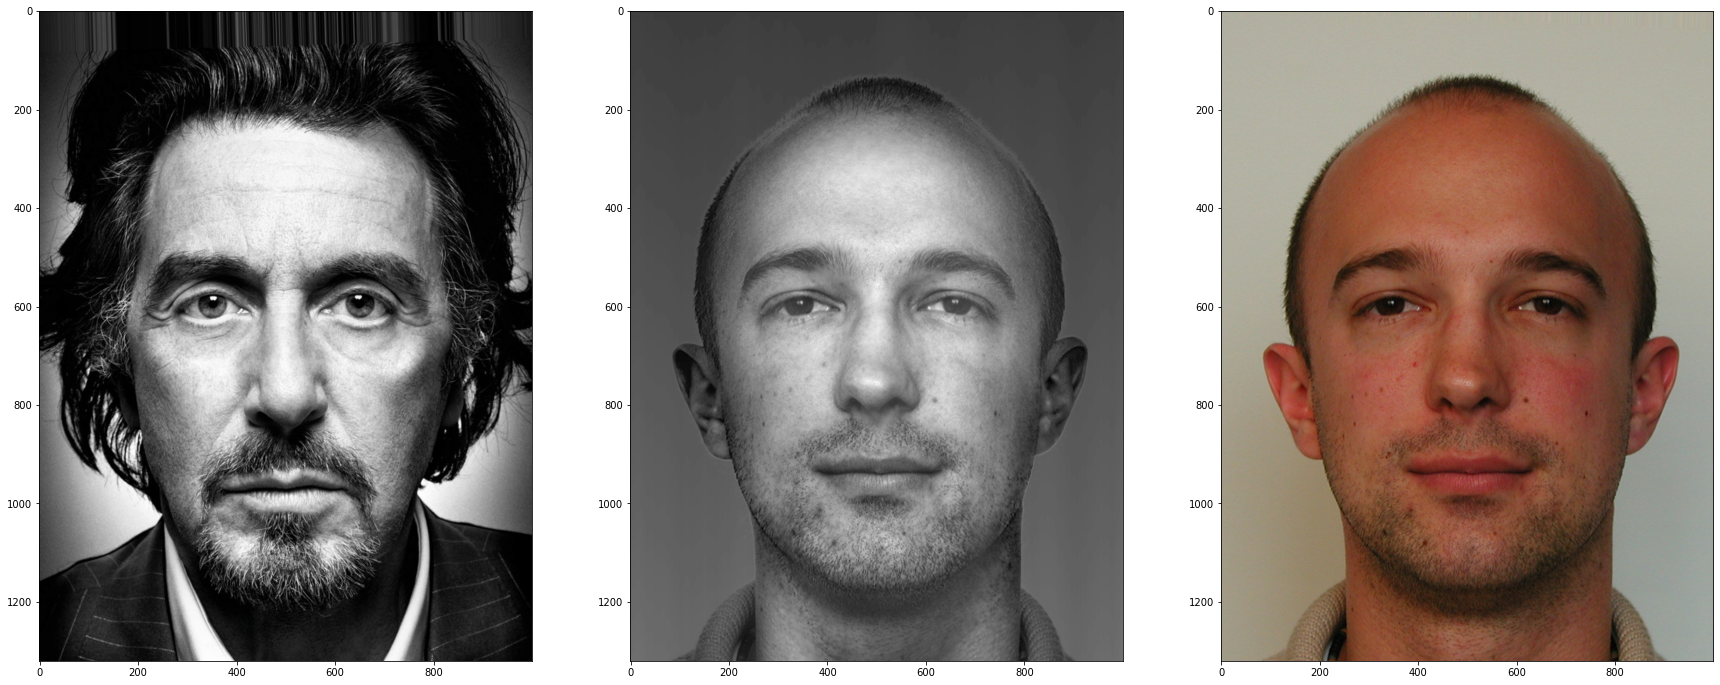

In [16]:
###### plotting outputs
refImgrgb=cv2.cvtColor(refImg.astype(np.uint8),cv2.COLOR_Lab2RGB)
inputImgrgb=cv2.cvtColor(inputImg.astype(np.uint8),cv2.COLOR_Lab2RGB)

fig = plt.figure(figsize=(30, 30))
fig.add_subplot(1, 3, 1)
plt.imshow(refImgrgb)
fig.add_subplot(1, 3, 2)
plt.imshow(outImg,cmap='gray')
# plt.imshow(cv2.cvtColor(outImg, cv2.COLOR_BGR2GRAY),cmap='gray')
# plt.imshow(inputImg_transformed_u8_rgb)
fig.add_subplot(1, 3, 3)
plt.imshow(inputImgrgb)
